# Assignment
Implement a classification script based on the fine tuning of a neural network, following the guidelines shown during the laboratory.

Rules:

* Use the same 101-object dataset
* Use a different architecture (i.e. no mobile net)
* Experiment with Data augmentation operations

\* **BEFORE ANYTHING ELSE SET GPU** \*
1. Open Runtime menu on top taskbar
2. Change runtime type
3. Set GPU as hardware accelerator
4. Click Save

# Importing libraries
Importo le librerie e i pacchetti necessari al corretto funzionamento del notebook. Oltre a ciò anche i dati da estrarre dal file zip

In [13]:
from tensorflow import keras
import tarfile
from shutil import copyfile

from tensorflow.keras.applications import Xception

import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
copyfile('gdrive/MyDrive/101_ObjectCategories_split.tar','101_ObjectCategories_split.tar')
tar=tarfile.open('101_ObjectCategories_split.tar')
tar.extractall()
tar.close()

# Data loader
Creazione dei dataset di training e di test derivanti dalle omonime cartelle estratte dal file zip

In [15]:
train_dataset=keras.preprocessing.image_dataset_from_directory(
    '101_ObjectCategories_split/train',
    image_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    label_mode='categorical',
    shuffle=True,
    seed=1
)

Found 4600 files belonging to 102 classes.


In [16]:
test_dataset=keras.preprocessing.image_dataset_from_directory(
    '101_ObjectCategories_split/test',
    image_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    label_mode='categorical',
    shuffle=True,
    seed=1
)

Found 4544 files belonging to 102 classes.


# Xception (no data augmentation)
Si è scelto arbitrariamente come modello di partenza Xception, tra quelli reperibili al seguente link: https://keras.io/api/applications/

In [17]:
xception_base=keras.applications.Xception(
    input_shape=(224,224,3),
    weights='imagenet',
    include_top=False,
    pooling='avg'
)

83697664/83683744 [==============================] - 1s 0us/step


In [18]:
len(xception_base.layers) #133 layers

133

In [19]:
xception_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

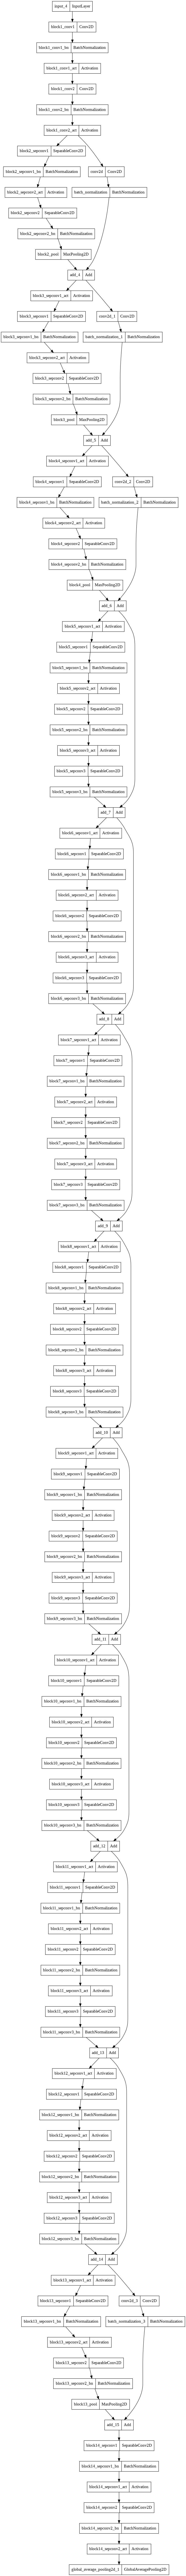

In [20]:
keras.utils.plot_model(xception_base)

Model specialization: inizialmente "congeliamo" i layers della rete di base. Per ciascun layer di Xception settiamo trainable = False. Non lo andiamo ad addestrare ma ereditiamo i pesi così come sono per accelerare il processo computazionale

In [21]:
for layer in xception_base.layers:
  layer.trainable=False

Definiamo il macro-modello

In [22]:
inputs = keras.Input(shape=(224,224,3))
x = inputs

# preprocessing
x = keras.applications.xception.preprocess_input(x)
# applicazione rete base (xception)
x = xception_base(x)
# layer aggiuntivi
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dense(102, activation='softmax')(x)

outputs=x

In [23]:
net = keras.Model(inputs=inputs,outputs=outputs)

In [24]:
net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 102)               104550

In [25]:
net.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [26]:
net_fit = net.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
144/144 [==============================] - 104s 633ms/step - loss: 1.0892 - accuracy: 0.7480 - val_loss: 0.8046 - val_accuracy: 0.8068
Epoch 2/5
144/144 [==============================] - 89s 616ms/step - loss: 0.2748 - accuracy: 0.9174 - val_loss: 0.4397 - val_accuracy: 0.8820
Epoch 3/5
144/144 [==============================] - 89s 617ms/step - loss: 0.1218 - accuracy: 0.9615 - val_loss: 0.5333 - val_accuracy: 0.8783
Epoch 4/5
144/144 [==============================] - 89s 618ms/step - loss: 0.1006 - accuracy: 0.9726 - val_loss: 0.4808 - val_accuracy: 0.8979
Epoch 5/5
144/144 [==============================] - 89s 616ms/step - loss: 0.0668 - accuracy: 0.9820 - val_loss: 0.5665 - val_accuracy: 0.8836


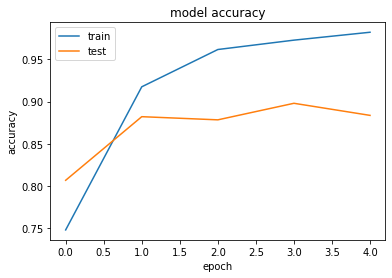

In [27]:
plt.plot(net_fit.history['accuracy'])
plt.plot(net_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Xception (data augmentation)
Si sperimenta l'uso di alcuni layers di data augmentation nella macro rete
https://keras.io/api/layers/preprocessing_layers/image_augmentation/

In [28]:
xception_aug=keras.applications.Xception(
    input_shape=(224,224,3),
    weights='imagenet',
    include_top=False,
    pooling='avg'
)

Model specialization: identica alla precedente

In [29]:
for layer in xception_aug.layers:
  layer.trainable=False

Definiamo il macro-modello con l'aggiunta di qualche layer di data augmentation

In [30]:
inputs = keras.Input(shape=(224,224,3))
x = inputs

# data agumentation
x = keras.layers.RandomContrast(factor=(0.3,0.5))(x) #contrasto casuale in un range dato [1-0.3,1+0.5]
x = keras.layers.RandomFlip(mode='horizontal_and_vertical')(x) #flip orizzontale o verticale
x = keras.layers.RandomRotation(factor=(-0.2,0.3))(x) #rotazione casuale in un range dato [-20%*2pi,30*2pi]

# preprocessing
x = keras.applications.xception.preprocess_input(x)
# applicazione rete base (xception)
x = xception_aug(x)
# layer aggiuntivi
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dense(102, activation='softmax')(x)

outputs=x

In [31]:
net_aug = keras.Model(inputs=inputs,outputs=outputs)

In [32]:
net_aug.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0         
 rast)                                                           
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                           

In [33]:
net_aug.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [34]:
net_aug_fit = net_aug.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/5
144/144 [==============================] - 95s 634ms/step - loss: 1.7765 - accuracy: 0.5852 - val_loss: 0.8371 - val_accuracy: 0.7709
Epoch 2/5
144/144 [==============================] - 91s 629ms/step - loss: 0.7886 - accuracy: 0.7750 - val_loss: 0.5955 - val_accuracy: 0.8277
Epoch 3/5
144/144 [==============================] - 90s 628ms/step - loss: 0.6010 - accuracy: 0.8274 - val_loss: 0.5910 - val_accuracy: 0.8371
Epoch 4/5
144/144 [==============================] - 90s 627ms/step - loss: 0.5299 - accuracy: 0.8439 - val_loss: 0.5007 - val_accuracy: 0.8627
Epoch 5/5
144/144 [==============================] - 90s 627ms/step - loss: 0.4297 - accuracy: 0.8689 - val_loss: 0.5717 - val_accuracy: 0.8583


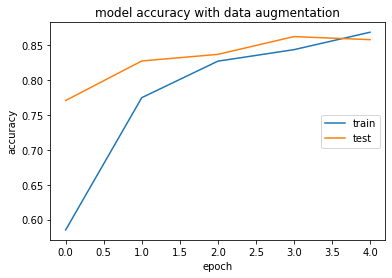

In [36]:
plt.plot(net_aug_fit.history['accuracy'])
plt.plot(net_aug_fit.history['val_accuracy'])
plt.title('model accuracy with data augmentation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='center right')
plt.show()

Come da aspettative le performance, in termini di training accuracy e test accuracy, sono leggermente peggiorate.